C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\3046684783.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\3046684783.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  TOTel_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(TOTel_df), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\3046684783.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max_effekt = TOTel_df["TOTel"].resample("M").max()  # Högsta värde per månad
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\3046684783.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["E"].resample("M").mean()
C:\Users\jak

Summa kostnad i el 2023: 59635886.22332853

Genomsnittligt dagligt Depth of Discharge (DoD) under året: 23.06%
Justerad elkostnad simulering: 44966779.2006342


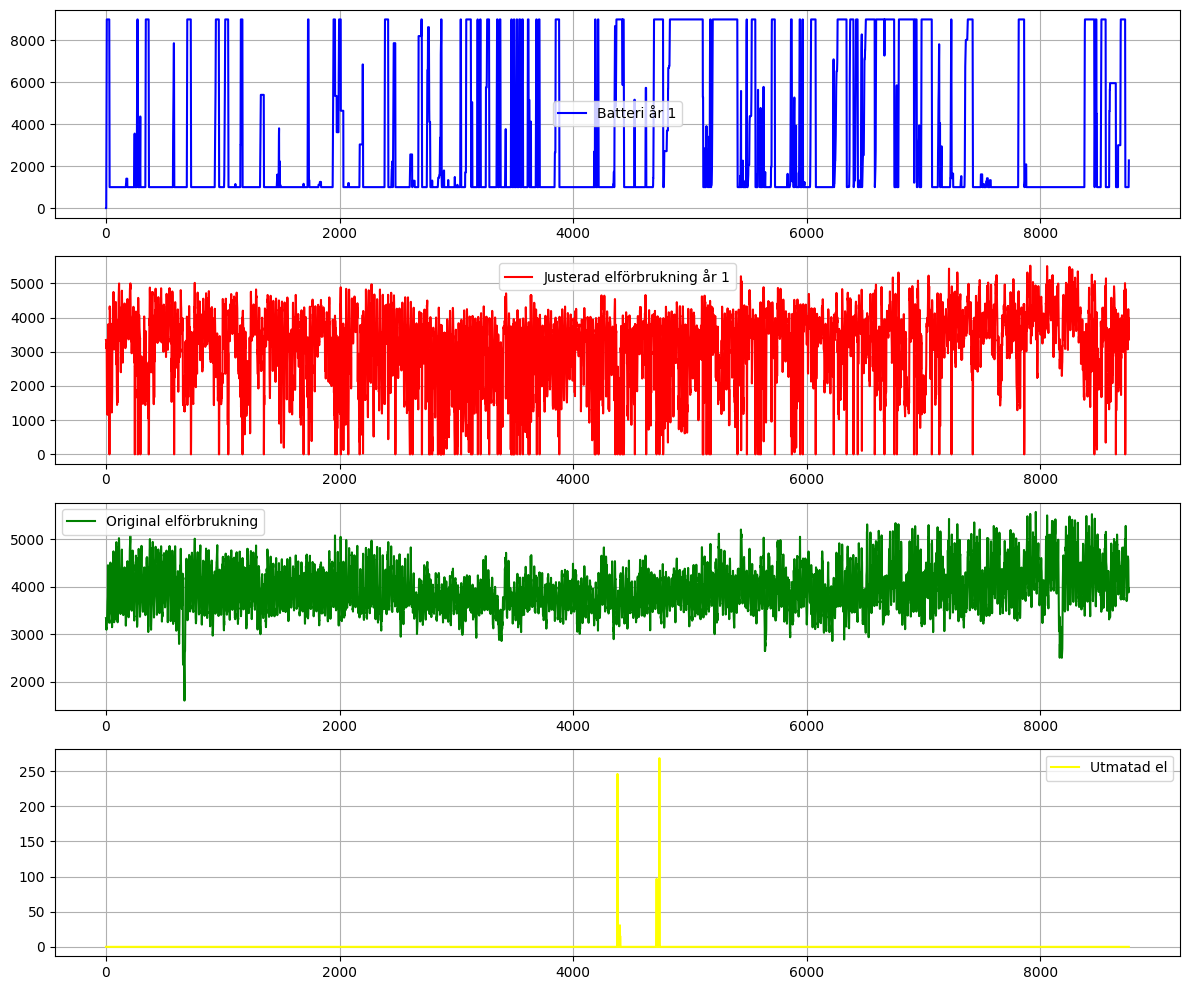

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
SolprodSödra = pd.read_excel("Soldata-filerSÖDRA/SummaSödraSolPROD.xlsx", header=None)
SödraOmrEL = pd.read_excel("Eldata-filerSÖDRA/SummaSödraOmrådet.xlsx", header=None)

SolprodABK = pd.read_excel("SolprodABK.xlsx", header=None)
ABKEl = pd.read_excel("ABKEL.xlsx", names=["ABKEl"], header=None)
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"], header=None)
Vindprod = pd.read_excel("Vindturbin.xlsx", header=None)
StarkaEl = pd.read_excel("Starka2023.xlsx", header=None)
KLTel = pd.read_excel("KLTelFörbr.xlsx", header=None)

NorraEL = StarkaEl.iloc[:, 0] + ABKEl.iloc[:, 0] + KLTel.iloc[:, 0]
SödraEL = SödraOmrEL.iloc[:, 0]
TOTel = NorraEL + SödraEL
Vind = Vindprod.iloc[:, 0]
Sol = 0.3*(SolprodABK.iloc[:, 0] + SolprodSödra.iloc[:, 0])
Spot = Spotpris.iloc[:, 0]

Prod = Vind + Sol

Prod_list = Prod.tolist()


Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

fastNätTOT = 342710

# Lägg till tidsindex för TOTel
TOTel_df = pd.DataFrame({"TOTel": TOTel})
TOTel_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(TOTel_df), freq="H")
TOTel_df.set_index("Tid", inplace=True)

# Hitta maximal timmedeleffekt per månad
monthly_max_effekt = TOTel_df["TOTel"].resample("M").max()  # Högsta värde per månad

# Effektavgift (per kW)
effektavgift = 57.04  # kr/kW

# Beräkna effektkostnad per månad
effektkostnad_per_månad = monthly_max_effekt * effektavgift  # Kostnad per månad

# Summera effektkostnaden för hela året
total_effektkostnad = effektkostnad_per_månad.sum()

Spotpris["E"] = 2.23 + 0.0583 * Spotpris["Spotpris"]

# Beräkna genomsnittlig överföringsavgift per månad
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna totala elförbrukningen per månad
monthly_total_TOTel = TOTel_df["TOTel"].resample("M").sum()

# Beräkna summa överföringsavgift för hela året
summaÖverföringsAvgift = (monthly_avg_E * monthly_total_TOTel).sum()

totElnätskostnad = fastNätTOT + total_effektkostnad + summaÖverföringsAvgift/100

elhandelskostnad = (Spot * TOTel).sum() / 100
energiskatt = (43.9 * TOTel).sum() / 100

summaElKostnad = (totElnätskostnad + elhandelskostnad + energiskatt) * 1.25
print("Summa kostnad i el 2023:", summaElKostnad)

# Ta fram elförbrukning (första kolumnen) som en Pandas Series
elförbrukning = pd.Series(TOTel)

# Sortera elförbrukningen i fallande ordning och hämta de 30 högsta värdena
top_30_hours = elförbrukning.sort_values(ascending=False).head(30)

# Skapa en DataFrame med radnummer (index) och värde (elförbrukning)
top_30_with_index = top_30_hours.reset_index()

# Byt namn på kolumnerna för bättre läsbarhet
top_30_with_index.columns = ['Timme', 'Elförbrukning']

# Skriv ut de 30 timmarna med högst elförbrukning och radnummer
print("Original elförbrukning topptimmar: " + top_30_with_index.to_string())


# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 10000  # Max battery capacity in kWh
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9
maxFrånBatteri = max_battery_level*0.5
faktor = 0.1
original_consumption = TOTel.tolist()
justeradElförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
utmatning = []
köptaTimmar = []

for tid, prod, totEl, spot in zip(Spotpris.index, Prod, TOTel, Spot):  
    diff = totEl - prod  # Skillnad mellan förbrukning och solproduktion

    if diff <= 0:
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        batteriKapacitet = min(batteriKapacitet - diff, max_battery_level)  # -diff eftersom diff är negativ
        justeradElförbrukning.append(0)  # Vi behöver inte köpa el
        utmatning.append(max(0,batteriKapacitet - diff - max_battery_level))
        köptaTimmar.append((tid,0))
    else:
        if spot <= 30 and prod > 0:
            if batteriKapacitet + prod >= max_battery_level: 
                prodÖver = (batteriKapacitet + prod) - max_battery_level
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                köpt_el = max(0, totEl-prodÖver)
                justeradElförbrukning.append(köpt_el)  
                köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
                utmatning.append(0)
            else:
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                justeradElförbrukning.append(totEl)
                köptaTimmar.append((tid, spot))
                utmatning.append(0)  
        elif 30 < spot < 70 and prod > 0:
            justeradElförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)
        elif spot >= 70:
            energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri, batteriKapacitet-min_battery_level)
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            justeradElförbrukning.append(köpt_el)
            utmatning.append(0)
        else:
            justeradElförbrukning.append(totEl)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)


    battery_values.append(batteriKapacitet)


# Skapa DataFrame med tidsindex och batterinivå
battery_df = pd.DataFrame({
    "Tid": Spotpris.index[:len(battery_values)],
    "Batteri": battery_values
})
battery_df.set_index("Tid", inplace=True)

# Räkna ut daglig max och min batterinivå
daily_max = battery_df["Batteri"].resample("D").max()
daily_min = battery_df["Batteri"].resample("D").min()

# Räkna ut DoD per dag i procent
daily_DoD = (daily_max - daily_min) / batteriMaxKapacitet * 100

# Räkna ut genomsnittligt dagligt DoD
average_DoD = daily_DoD.mean()

print(f"\nGenomsnittligt dagligt Depth of Discharge (DoD) under året: {average_DoD:.2f}%")

# Konvertera elförbrukning till en NumPy-array
elförbrukning_array = np.array(justeradElförbrukning)

# Hitta de 30 högsta värdena i elförbrukning
top_30_indices = np.argsort(elförbrukning_array)[-30:]  # Index för de 30 största värdena

# Hämta de faktiska tidsstämplarna från Spotpris.index
top_30_times = Spotpris.index[top_30_indices]

# Hämta de 30 största elförbrukningsvärdena
top_30_values = elförbrukning_array[top_30_indices]

# Sortera topp 30 i fallande ordning och behåll index
sorted_pairs = sorted(zip(top_30_values, top_30_times), reverse=True)

# Skriv ut de 30 högsta värdena tillsammans med originaltimmarna
print("De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:")
for i, (value, original_time) in enumerate(sorted_pairs):
    excel_rad = i + 8  # +8 för rubrikrad och 1-baserade index, och +1 för att börja från 1
    print(f"{i+1}. Timme {original_time}  - Förbrukning: {value} (Excel rad: {excel_rad})")


köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

köptaTimmar_df["E"] = 2.23 + 0.0583 * köptaTimmar_df["Spotpris"]

monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()

elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": justeradElförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()

summaJusteradÖverf = (monthly_avg_E_köpt * monthly_total_elförbrukning).sum()

summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastNätTOT

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(justeradElförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100


# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (summaJusteradÖverfKR + JusteradEnergiskatt + elhandelskostnad_köpt)
print("Justerad elkostnad simulering:", summaJusteradElkostnad)


# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(justeradElförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
ax[3].plot(utmatning, label='Utmatad el', color='orange')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

# Skapa en figur och plotta
plt.figure(figsize=(12, 6))
plt.plot(Prod_list, label="Prod", color="yellow")

plt.xlabel("Tid")
plt.ylabel("Produktion (kWh)")
plt.title("Vind och solprod")
plt.legend()
plt.grid(True)

# Visa grafen
plt.show()


In [14]:
from scipy.optimize import minimize

def simulera(trösklar):
    ladda_gräns, använd_gräns = trösklar
    
    # Samma förberedelser som innan
    batteriKapacitet = 0.0
    batteriMaxKapacitet = 10000
    min_battery_level = batteriMaxKapacitet * 0.1
    max_battery_level = batteriMaxKapacitet * 0.9
    maxFrånBatteri = max_battery_level * 0.5
    justeradElförbrukning = []
    battery_values = []
    utmatning = []
    köptaTimmar = []

    for tid, prod, totEl, spot in zip(Spotpris.index, Prod, TOTel, Spot):
        diff = totEl - prod
        if diff <= 0:
            batteriKapacitet = min(batteriKapacitet - diff, max_battery_level)
            justeradElförbrukning.append(0)
            utmatning.append(max(0, batteriKapacitet - diff - max_battery_level))
            köptaTimmar.append((tid, 0))
        else:
            if spot <= ladda_gräns and prod > 0:
                if batteriKapacitet + prod >= max_battery_level:
                    prodÖver = (batteriKapacitet + prod) - max_battery_level
                    batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                    köpt_el = max(0, totEl - prodÖver)
                    justeradElförbrukning.append(köpt_el)
                    köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
                    utmatning.append(0)
                else:
                    batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                    justeradElförbrukning.append(totEl)
                    köptaTimmar.append((tid, spot))
                    utmatning.append(0)
            elif ladda_gräns < spot < använd_gräns and prod > 0:
                justeradElförbrukning.append(diff)
                köptaTimmar.append((tid, spot))
                utmatning.append(0)
            elif spot >= använd_gräns:
                energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri, batteriKapacitet - min_battery_level)
                batteriKapacitet -= energiFrånBatteri
                köpt_el = max(0, diff - energiFrånBatteri)
                köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
                justeradElförbrukning.append(köpt_el)
                utmatning.append(0)
            else:
                justeradElförbrukning.append(totEl)
                köptaTimmar.append((tid, spot))
                utmatning.append(0)
        battery_values.append(batteriKapacitet)

    # Kostnadsberäkning
    köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
    köptaTimmar_df.set_index("Tid", inplace=True)
    köptaTimmar_df["E"] = 2.23 + 0.0583 * köptaTimmar_df["Spotpris"]

    elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": justeradElförbrukning})
    elförbrukning_df.set_index("Tid", inplace=True)
    
    monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
    monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()
    summaJusteradÖverf = (monthly_avg_E_köpt * monthly_total_elförbrukning).sum()
    summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastNätTOT

    elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]
    elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100
    JusteradEnergiskatt = (sum(justeradElförbrukning) * 43.9) / 100

    totalKostnad = 1.25 * (summaJusteradÖverfKR + JusteradEnergiskatt + elhandelskostnad_köpt)
    return totalKostnad

# Funktion att minimera
def objective(trösklar):
    if trösklar[0] >= trösklar[1]:  # säkerställ att laddgräns < användgräns
        return 1e10
    return simulera(trösklar)

# Startgissning och begränsningar
initial_guess = [30, 70]
bounds = [(0, 100), (0, 100)]

result = minimize(objective, initial_guess, bounds=bounds)

print("Optimala tröskelvärden (öre/kWh):", result.x)
print("Minimerad kostnad:", result.fun)

print("Kostnad med trösklar 30/70:", simulera([30, 70]))
print("Kostnad med trösklar 20/80:", simulera([20, 80]))
print("Kostnad med trösklar 40/60:", simulera([40, 60]))



C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\457826549.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\457826549.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\457826549.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\457826549.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()
C:\Users\jakob\AppData\Local\Temp\ipyker

Optimala tröskelvärden (öre/kWh): [30. 70.]
Minimerad kostnad: 45690733.771337904
Kostnad med trösklar 30/70: 45690733.771337904
Kostnad med trösklar 20/80: 45819150.121787265


C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\457826549.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\457826549.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()


Kostnad med trösklar 40/60: 45662766.364519134


C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\457826549.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\457826549.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()


C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\3524224689.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\3524224689.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  TOTel_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(TOTel_df), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\3524224689.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max_effekt = TOTel_df["TOTel"].resample("M").max()  # Högsta värde per månad
C:\Users\jakob\AppData\Local\Temp\ipykernel_5580\3524224689.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["E"].resample("M").mean()
C:\Users\jak

Summa kostnad i el 2023: 59635886.22332853

Genomsnittligt dagligt Depth of Discharge (DoD) under året: 3.18%
Justerad elkostnad simulering: 43509540.040058136


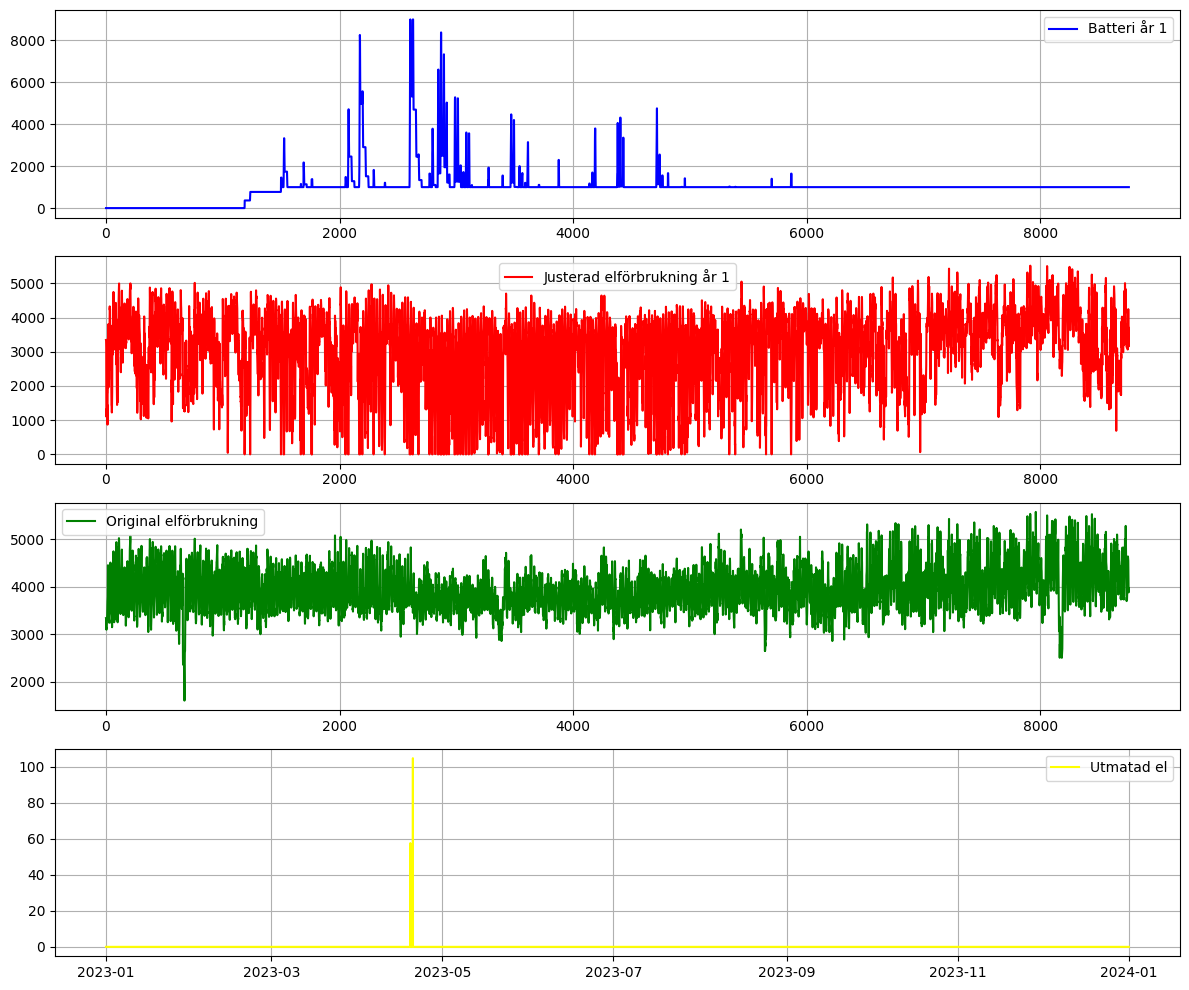

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
SolprodSödra = pd.read_excel("Soldata-filerSÖDRA/SummaSödraSolPROD.xlsx", header=None)
SödraOmrEL = pd.read_excel("Eldata-filerSÖDRA/SummaSödraOmrådet.xlsx", header=None)

SolprodABK = pd.read_excel("SolprodABK.xlsx", header=None)
ABKEl = pd.read_excel("ABKEL.xlsx", names=["ABKEl"], header=None)
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"], header=None)
Vindprod = pd.read_excel("Vindturbin.xlsx", header=None)
StarkaEl = pd.read_excel("Starka2023.xlsx", header=None)
KLTel = pd.read_excel("KLTelFörbr.xlsx", header=None)

NorraEL = StarkaEl.iloc[:, 0] + ABKEl.iloc[:, 0] + KLTel.iloc[:, 0]
SödraEL = SödraOmrEL.iloc[:, 0]
TOTel = NorraEL + SödraEL
Vind = Vindprod.iloc[:, 0]
Sol = 0.46*(SolprodABK.iloc[:, 0] + SolprodSödra.iloc[:, 0])
Spot = Spotpris.iloc[:, 0]

Prod = Vind + Sol

Prod_list = Prod.tolist()


Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

fastNätTOT = 342710

# Lägg till tidsindex för TOTel
TOTel_df = pd.DataFrame({"TOTel": TOTel})
TOTel_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(TOTel_df), freq="H")
TOTel_df.set_index("Tid", inplace=True)

# Hitta maximal timmedeleffekt per månad
monthly_max_effekt = TOTel_df["TOTel"].resample("M").max()  # Högsta värde per månad

# Effektavgift (per kW)
effektavgift = 57.04  # kr/kW

# Beräkna effektkostnad per månad
effektkostnad_per_månad = monthly_max_effekt * effektavgift  # Kostnad per månad

# Summera effektkostnaden för hela året
total_effektkostnad = effektkostnad_per_månad.sum()

Spotpris["E"] = 2.23 + 0.0583 * Spotpris["Spotpris"]

# Beräkna genomsnittlig överföringsavgift per månad
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna totala elförbrukningen per månad
monthly_total_TOTel = TOTel_df["TOTel"].resample("M").sum()

# Beräkna summa överföringsavgift för hela året
summaÖverföringsAvgift = (monthly_avg_E * monthly_total_TOTel).sum()

totElnätskostnad = fastNätTOT + total_effektkostnad + summaÖverföringsAvgift/100

elhandelskostnad = (Spot * TOTel).sum() / 100
energiskatt = (43.9 * TOTel).sum() / 100

summaElKostnad = (totElnätskostnad + elhandelskostnad + energiskatt) * 1.25
print("Summa kostnad i el 2023:", summaElKostnad)

# Ta fram elförbrukning (första kolumnen) som en Pandas Series
elförbrukning = pd.Series(TOTel)

# Sortera elförbrukningen i fallande ordning och hämta de 30 högsta värdena
top_30_hours = elförbrukning.sort_values(ascending=False).head(30)

# Skapa en DataFrame med radnummer (index) och värde (elförbrukning)
top_30_with_index = top_30_hours.reset_index()

# Byt namn på kolumnerna för bättre läsbarhet
top_30_with_index.columns = ['Timme', 'Elförbrukning']

# Skriv ut de 30 timmarna med högst elförbrukning och radnummer
print("Original elförbrukning topptimmar: " + top_30_with_index.to_string())


# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 10000  # Max battery capacity in kWh
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9
maxFrånBatteri = max_battery_level*0.5
faktor = 0.1
original_consumption = TOTel.tolist()
justeradElförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
utmatning = []
köptaTimmar = []

for i, (tid, prod, totel, spot) in enumerate(zip(Spotpris.index, Prod, TOTel, Spot)):
    diff = totel - prod  # Difference between consumption and solar production


    if i < 2800:
        faktor = 0.15
    elif  2500 <= i <= 7500:
        faktor = 0.3
    else:
        faktor = 0.07

    if diff <= 0:
        if batteriKapacitet - diff >= max_battery_level:
            utmatEl = batteriKapacitet - diff - max_battery_level
            utmatning.append((tid, utmatEl))
            batteriKapacitet = max_battery_level  # -diff eftersom diff är negativ
        else:
            utmatning.append((tid, 0))
            batteriKapacitet = batteriKapacitet - diff
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        justeradElförbrukning.append(0)  # Vi behöver inte köpa el
        köptaTimmar.append((tid,0))
    else:  
        
        if 15 <= tid.hour < 19 and prod == 0:
            energiFrånBatteri = min(batteriKapacitet * faktor, maxFrånBatteri, max(0, batteriKapacitet - min_battery_level))

            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, totel - energiFrånBatteri)
            justeradElförbrukning.append(köpt_el)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append((tid, 0))
        elif 15 <= tid.hour < 19 and prod > 0:
            energiFrånBatteri = min(batteriKapacitet * faktor, diff, maxFrånBatteri, max(0, batteriKapacitet - min_battery_level))

            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            justeradElförbrukning.append(köpt_el)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append((tid, 0))
        elif prod > 0:
            justeradElförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append((tid,0))
            
        else:
            justeradElförbrukning.append(totel)  
            köptaTimmar.append((tid, spot))
            utmatning.append((tid, 0))

    
    battery_values.append(batteriKapacitet)


# Skapa DataFrame med tidsindex och batterinivå
battery_df = pd.DataFrame({
    "Tid": Spotpris.index[:len(battery_values)],
    "Batteri": battery_values
})
battery_df.set_index("Tid", inplace=True)

# Räkna ut daglig max och min batterinivå
daily_max = battery_df["Batteri"].resample("D").max()
daily_min = battery_df["Batteri"].resample("D").min()

# Räkna ut DoD per dag i procent
daily_DoD = (daily_max - daily_min) / batteriMaxKapacitet * 100

# Räkna ut genomsnittligt dagligt DoD
average_DoD = daily_DoD.mean()

print(f"\nGenomsnittligt dagligt Depth of Discharge (DoD) under året: {average_DoD:.2f}%")

# Konvertera elförbrukning till en NumPy-array
elförbrukning_array = np.array(justeradElförbrukning)

# Hitta de 30 högsta värdena i elförbrukning
top_30_indices = np.argsort(elförbrukning_array)[-30:]  # Index för de 30 största värdena

# Hämta de faktiska tidsstämplarna från Spotpris.index
top_30_times = Spotpris.index[top_30_indices]

# Hämta de 30 största elförbrukningsvärdena
top_30_values = elförbrukning_array[top_30_indices]

# Sortera topp 30 i fallande ordning och behåll index
sorted_pairs = sorted(zip(top_30_values, top_30_times), reverse=True)

# Skriv ut de 30 högsta värdena tillsammans med originaltimmarna
print("De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:")
for i, (value, original_time) in enumerate(sorted_pairs):
    excel_rad = i + 8  # +8 för rubrikrad och 1-baserade index, och +1 för att börja från 1
    print(f"{i+1}. Timme {original_time}  - Förbrukning: {value} (Excel rad: {excel_rad})")

köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

köptaTimmar_df["E"] = 2.23 + 0.0583 * köptaTimmar_df["Spotpris"]

monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()

elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": justeradElförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()

summaJusteradÖverf = (monthly_avg_E_köpt * monthly_total_elförbrukning).sum()

summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastNätTOT

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(justeradElförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100


# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (summaJusteradÖverfKR + JusteradEnergiskatt + elhandelskostnad_köpt)
print("Justerad elkostnad simulering:", summaJusteradElkostnad)


# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(justeradElförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
utmat_tid, utmat_värde = zip(*utmatning)
ax[3].plot(utmat_tid, utmat_värde, label='Utmatad el', color='orange')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

# Skapa en figur och plotta
plt.figure(figsize=(12, 6))
plt.plot(Prod_list, label="Prod", color="yellow")

plt.xlabel("Tid")
plt.ylabel("Produktion (kWh)")
plt.title("Vind och solprod")
plt.legend()
plt.grid(True)

# Visa grafen
plt.show()
